# 3. Classification
___

Lets use the MNSIT data set

In [8]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

In [9]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [12]:
sort_by_target(mnist)

In [13]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

Let's see one digit from the dataset

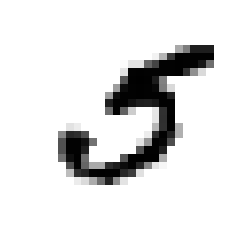

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation='nearest')
plt.axis('off')
plt.show()

Let's split the data into the test set and training set

In [21]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

A commonly used classifier is the Stochastic Gradient Descent or SGD, we will train it ro detect if a number is a five or no.

In [22]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5);

In [26]:
sgd_clf.predict([some_digit])

array([ True])

Evaluating a classifier is significantly trickier than evaluating a regressor. A good way to evaluate a model is to use cross-validation.

In [28]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96725, 0.97105, 0.96665])

In [31]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.9088 , 0.9089 ])

Another way to evaluate the performance of a classifier is to look at the confusion matrix.

In [34]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53602,   977],
       [  924,  4497]], dtype=int64)

From the confusion matrix we can get the precision and the recall

In [40]:
from sklearn.metrics import precision_score, recall_score

print('Precision:',precision_score(y_train_5, y_train_pred),
     'Recall:',recall_score(y_train_5, y_train_pred))

Precision: 0.8215199123127512 Recall: 0.8295517432208079


This means that when the classifier claims an image is a 5 it is correct only 82% of the time. Moreover, it only detects 83% of the 5's. The F1 combines the precision and recall in a single metric which is high if both evualuations are high.

In [44]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8255162918770078

There is a precision/recall tradeoff. So how can you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions:

In [45]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

In [47]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

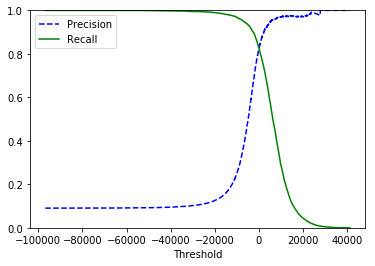

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

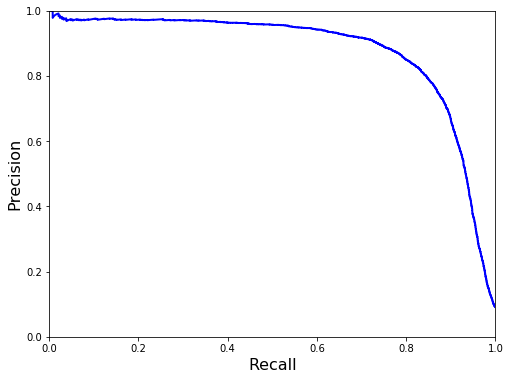

In [70]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [68]:
y_train_pred_90 = ()
precision_score(y_train_5, y_scores > 2000)

0.8900810159842347

In [71]:
recall_score(y_train_5, y_scores > 2000)

0.7498616491422246

The receiver operating characterisitc (ROC) curve is another tool to use with binary classifiers. The ROC plots true positive rate (Recall) vs flase positive rate

In [72]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

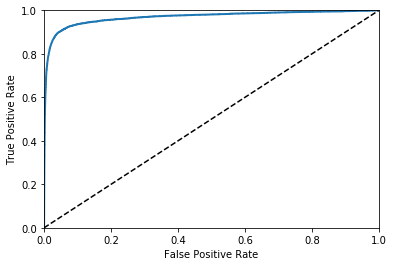

In [73]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff, the higher the TPR the more false positives the classifier produces. A good classifier stays as far away from the dotted line as possible.

In [74]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9685836741732619

The precision/recall curve is prefered whenever the positive class is rare or when you care more about the flase positives than false negatives.

Let's see how a Random forest classifier compares against SGDC.

In [76]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10,random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

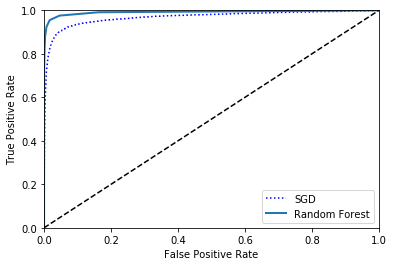

In [79]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [80]:
roc_auc_score(y_train_5, y_scores_forest)

0.9918183005147831

Let's try to run a multiclass classifier

In [81]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [83]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -4142.49263372, -28110.20664279, -13414.76401355,
         -4631.99159132, -10561.81663746,   5394.9732241 ,
        -40287.72782232, -12932.42514326, -13938.05614175,
        -11424.06404718]])

In [88]:
%%time
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

Wall time: 4min 33s


array([0.8825235 , 0.8920446 , 0.88618293])

In [86]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.89197161, 0.89939497, 0.89958494])

Let's analyze the type of errors that the model makes.

In [89]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5590,    0,   13,    7,    7,   35,   32,    5,  233,    1],
       [   0, 6401,   44,   21,    2,   45,    4,    7,  210,    8],
       [  23,   27, 5231,   83,   72,   21,   68,   36,  390,    7],
       [  25,   16,  115, 5216,    2,  176,   24,   41,  449,   67],
       [  10,   14,   41,    9, 5179,   11,   33,   21,  371,  153],
       [  27,   14,   28,  147,   58, 4428,   75,   17,  567,   60],
       [  28,   17,   47,    1,   42,   84, 5535,    8,  156,    0],
       [  18,   13,   55,   17,   44,   10,    4, 5686,  201,  217],
       [  13,   54,   43,   89,    2,  113,   30,    7, 5462,   38],
       [  25,   20,   26,   54,  125,   34,    1,  173,  400, 5091]],
      dtype=int64)

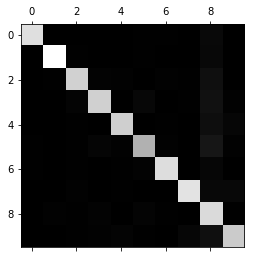

In [90]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

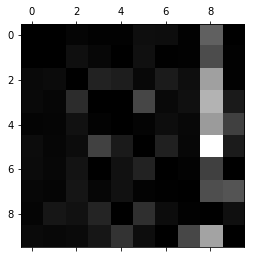

In [91]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


In [92]:
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5797,    4,   20,    9,    4,   17,   32,    2,   35,    3],
       [   3, 6622,   32,   20,   12,    4,    5,   16,   17,   11],
       [  47,   28, 5658,   41,   29,   23,   22,   57,   43,   10],
       [  23,   21,  132, 5613,    8,  140,   10,   54,   91,   39],
       [  19,   23,   32,   11, 5546,    9,   26,   22,   20,  134],
       [  59,   16,   36,  189,   32, 4931,   53,   10,   61,   34],
       [  54,   13,   30,    3,   32,   60, 5698,    0,   26,    2],
       [  11,   38,   82,   41,   87,   10,    0, 5881,   17,   98],
       [  39,   47,   89,  134,   62,  103,   44,   13, 5252,   68],
       [  29,   17,   26,   84,  178,   46,    8,   83,   51, 5427]],
      dtype=int64)

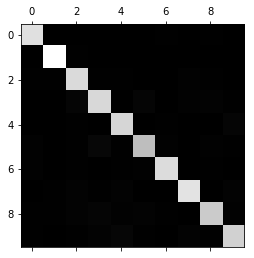

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

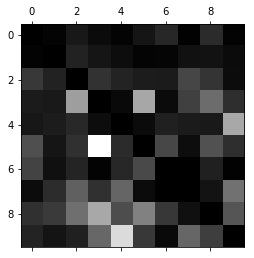

In [93]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [99]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_train_large

array([False, False, False, ..., False, False, False])